In [2]:
# Cell 1: Data Loading, Preprocessing, and Stratified Group Split
import pandas as pd
import numpy as np
from collections import defaultdict

# 1. Load the dataset, force Sample and AB as strings to avoid mixed types
df = pd.read_csv(
    './data300.csv',
    dtype={'Sample': str, 'AB': str},
    low_memory=False,
)
df['Sample'] = df['Sample'].astype(str)

# --- Normalize the Group column to exactly "Neg", "Pos", or "Fungi" ---
# 1) lower‐case and strip whitespace
df['Group'] = df['Group'].str.strip().str.lower()

# 2) map every variant you have to our three canonical keys
df['Group'] = df['Group'].map({
    'neg': 'Neg',
    'gram‐negative': 'Neg',
    'gram-negative bacteria': 'Neg',
    'pos': 'Pos',
    'gram‐positive': 'Pos',
    'gram-positive bacteria': 'Pos',
    'yeast': 'Fungi',           # <-- your “fungi” are tagged as “Yeast”
    'fungi': 'Fungi',           # in case any got through
})

# sanity check
print("Normalized groups:", df['Group'].unique())

# 2. Identify intensity columns (first 5 columns are metadata)
intensity_cols = df.columns[5:]

# 3. Min-max normalize each spectrum (each row) across the intensity columns
X_values = df[intensity_cols].to_numpy(dtype=np.float32)
mins = X_values.min(axis=1, keepdims=True)
maxs = X_values.max(axis=1, keepdims=True)
ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
X_norm = (X_values - mins) / ranges  # shape (N, num_wavelengths)

# 4. Encode species labels into integer classes
species_labels = df['ID'].astype(str).values
unique_species = sorted(np.unique(species_labels))
label_to_idx = {lab: i for i, lab in enumerate(unique_species)}
y_full = np.array([label_to_idx[s] for s in species_labels], dtype=np.int64)

# 5. Build a unique sample key per biological sample: "<Species>_<SampleID>"
df['sample_key'] = df['ID'].astype(str) + '_' + df['Sample'].astype(str)

# 6. Stratified selection of one sample_key per species for the test set
species_to_keys = defaultdict(list)
for key, species in zip(df['sample_key'], df['ID']):
    species_to_keys[species].append(key)

np.random.seed(42)
test_keys = []
for species, keys in species_to_keys.items():
    if len(keys) >= 2:
        # randomly select one key for test
        test_keys.append(np.random.choice(keys))
    # species with only one sample_key remain in train/val

# 7. Remaining keys for train+val
all_keys = set(df['sample_key'])
train_val_keys = list(all_keys - set(test_keys))
np.random.shuffle(train_val_keys)

# 8. Split train+val keys into 80% train, 20% val
n_train_val = len(train_val_keys)
n_train = int(0.8 * n_train_val)
train_keys = train_val_keys[:n_train]
val_keys   = train_val_keys[n_train:]

# 9. Build boolean masks for each split based on sample_key
train_mask = df['sample_key'].isin(train_keys)
val_mask   = df['sample_key'].isin(val_keys)
test_mask  = df['sample_key'].isin(test_keys)

# 10. Slice out X and y for each split
X_train, y_train = X_norm[train_mask], y_full[train_mask]
X_val,   y_val   = X_norm[val_mask],   y_full[val_mask]
X_test,  y_test  = X_norm[test_mask],  y_full[test_mask]

# 11. Sanity checks: counts and species coverage
print(f"Total spectra: {len(df)}")
print(f"Train spectra: {X_train.shape[0]}, Val spectra: {X_val.shape[0]}, Test spectra: {X_test.shape[0]}")

# Count per species in each split
import pandas as pd
train_counts = pd.Series(y_train).map(lambda i: unique_species[i]).value_counts()
val_counts   = pd.Series(y_val).map(lambda i: unique_species[i]).value_counts()
test_counts  = pd.Series(y_test).map(lambda i: unique_species[i]).value_counts()

print("\nTrain set species counts:\n", train_counts)
print("\nVal set species counts:\n", val_counts)
print("\nTest set species counts:\n", test_counts)

Normalized groups: ['Neg' 'Fungi' 'Pos']
Total spectra: 102600
Train spectra: 73200, Val spectra: 18600, Test spectra: 10800

Train set species counts:
 Eco     5100
Kox     3900
CrNe    3600
CaPa    3300
CaAl    3300
CaKr    3000
Api     3000
CaGu    2700
Ano     2700
CaTr    2700
CaGl    2400
Efa     2400
Ecl     2100
Eae     2100
Sau     1800
Shl     1800
Sma     1800
Cdi     1800
Stm     1800
Sca     1800
Pmi     1800
Pae     1500
Mmo     1500
Sho     1500
Bce     1500
Sep     1500
Bfg     1500
Kpn     1200
Cfr     1200
Aba     1200
Svi     1200
Sgc     1200
Sal      900
Lmo      900
Efm      900
Spn      600
Name: count, dtype: int64

Val set species counts:
 Api     1500
Ano     1500
CaTr    1200
CaGl    1200
Aba      900
Cfr      900
Spn      900
Efm      900
Efa      900
CaGu     900
CaKr     900
CaAl     600
Svi      600
Eco      600
Sgc      600
Mmo      600
Kpn      600
Kox      300
Bce      300
Stm      300
CaPa     300
Pmi      300
Lmo      300
Pae      300
Sal      300
Sm

In [3]:
import torch
import torch.nn as nn
import math

class RamanTransformerClassifier(nn.Module):
    def __init__(self, seq_len, num_classes, d_model=64, nhead=8, dim_feedforward=256, num_layers=2, dropout=0.1):
        """
        Initializes the Transformer-based classifier.
        seq_len: length of the input sequence (number of wavelength points, e.g., 1000)
        num_classes: number of output classes (species)
        d_model: dimensionality of the embedding/transformer model
        nhead: number of heads in multi-head attention
        dim_feedforward: dimensionality of the feedforward network in transformer layers
        num_layers: number of transformer encoder layers
        dropout: dropout rate for transformer layers
        """
        super(RamanTransformerClassifier, self).__init__()
        # Linear projection of input scalar to d_model-dimensional embedding
        self.value_embedding = nn.Linear(1, d_model)
        # Positional encoding (sinusoidal)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # shape [seq_len, 1]
        # Frequencies for sine/cosine positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pos_encoding[:, 0::2] = torch.sin(positions * div_term)  # apply sin to even indices in the embedding
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)  # apply cos to odd indices
        pos_encoding = pos_encoding.unsqueeze(0)  # shape [1, seq_len, d_model] for broadcasting
        # Register as buffer (not a parameter, but part of the state for usage)
        self.register_buffer('pos_encoding', pos_encoding)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
                                                  dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        """
        Forward pass for the model.
        x: input tensor of shape [batch_size, seq_len] containing normalized Raman intensities.
        """
        # Project each intensity value to a d_model-dimensional embedding
        # x is [batch, seq_len]; convert to [batch, seq_len, 1] for linear layer
        x = x.unsqueeze(-1)
        x = self.value_embedding(x)  # now x shape: [batch, seq_len, d_model]

        # Add positional encoding to include wavelength position information
        x = x + self.pos_encoding[:, :x.size(1), :]  # broadcasting over batch dimension

        # Pass through Transformer encoder layers
        x = self.transformer_encoder(x)  # shape remains [batch, seq_len, d_model]

        # Global average pooling over the sequence dimension
        x = x.mean(dim=1)  # shape: [batch, d_model]

        # Final classifier to get class logits
        logits = self.classifier(x)  # shape: [batch, num_classes]

        return logits

# Initialize the model
seq_length = X_train.shape[1]  # this should be 1000 (number of wavelength points)
num_classes = len(unique_species)
model = RamanTransformerClassifier(
    seq_len=seq_length,                                   
    num_classes=num_classes,                                   
    d_model=128,                                    
    nhead=8,                                    
    dim_feedforward=512,                                   
    num_layers=4, 
    dropout=0.2)

print(model)


RamanTransformerClassifier(
  (value_embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
)


In [4]:
import torch.optim as optim

# Set device for training (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model.to(device)

# Create DataLoader for batch training
batch_size = 512
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                               torch.tensor(y_train, dtype=torch.long))
val_dataset   = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                                               torch.tensor(y_val, dtype=torch.long))
test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                                               torch.tensor(y_test, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Training parameters
num_epochs = 100
patience = 15  # early stopping patience

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Containers to track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0


Using device: cuda


In [4]:
%%time

# 1. Compute total training steps and warmup length
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)   # 10% of all steps as warmup

# 2. Define the Lambda LR schedule
def lr_lambda(current_step):
    if current_step < warmup_steps:
        # linear warmup: from 0 → 1
        return float(current_step) / float(max(1, warmup_steps))
    # cosine decay: from 1 → 0
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 3. Training loop with scheduler.step()
global_step = 0
best_val_acc = 0.0
epochs_no_improve = 0


# Training loop with validation and early stopping
for epoch in range(1, num_epochs+1):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)            # forward pass
        loss = criterion(outputs, y_batch)  # compute loss
        loss.backward()                     # backpropagation
        optimizer.step()                    # update parameters

        # 4. Update LR schedule
        scheduler.step()
        global_step += 1
        
        epoch_train_loss += loss.item() * X_batch.size(0)  # accumulate loss (multiply by batch size for sum)
        # Compute number of correct predictions in this batch
        _, predicted = torch.max(outputs, dim=1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / total_train
    train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)
    avg_val_loss = epoch_val_loss / total_val if total_val > 0 else 0.0
    val_acc = correct_val / total_val if total_val > 0 else 0.0

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch:03d}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc*100:.2f}% | "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc*100:.2f}%")

    # Check for improvement in validation accuracy for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()  # save best model parameters
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"No improvement in validation accuracy for {patience} epochs. Early stopping at epoch {epoch}.")
        break

# If early stopping was triggered, best_model_state is not None
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model (validation accuracy = {:.2f}%) for final evaluation.".format(best_val_acc*100))


Epoch 001: Train Loss = 3.5227, Train Acc = 6.84% | Val Loss = 3.5090, Val Acc = 5.83%
Epoch 002: Train Loss = 3.1423, Train Acc = 15.37% | Val Loss = 3.0816, Val Acc = 13.91%
Epoch 003: Train Loss = 2.4779, Train Acc = 32.20% | Val Loss = 2.4479, Val Acc = 30.66%
Epoch 004: Train Loss = 1.8916, Train Acc = 52.72% | Val Loss = 2.2849, Val Acc = 39.40%
Epoch 005: Train Loss = 1.5945, Train Acc = 64.38% | Val Loss = 2.0352, Val Acc = 52.45%
Epoch 006: Train Loss = 1.4168, Train Acc = 71.24% | Val Loss = 2.0347, Val Acc = 52.40%
Epoch 007: Train Loss = 1.2947, Train Acc = 75.94% | Val Loss = 1.9936, Val Acc = 55.62%
Epoch 008: Train Loss = 1.1981, Train Acc = 79.96% | Val Loss = 1.8782, Val Acc = 60.13%
Epoch 009: Train Loss = 1.1293, Train Acc = 82.57% | Val Loss = 1.8127, Val Acc = 62.37%
Epoch 010: Train Loss = 1.0565, Train Acc = 85.55% | Val Loss = 1.7299, Val Acc = 66.84%
Epoch 011: Train Loss = 1.0234, Train Acc = 86.75% | Val Loss = 1.7023, Val Acc = 66.82%
Epoch 012: Train Loss =

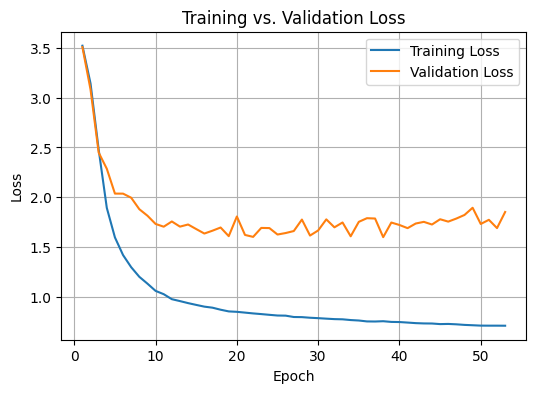

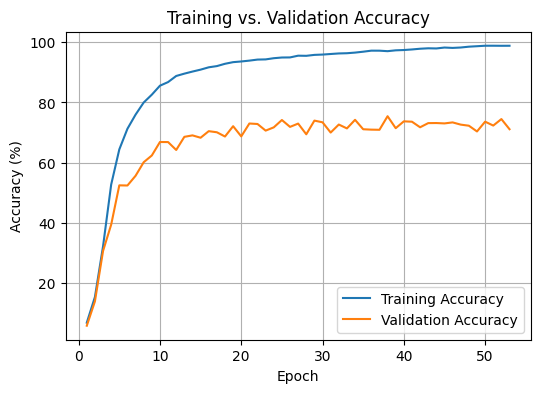

In [5]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)  # total epochs that ran (could be less than num_epochs if early stopped)
epoch_range = range(1, epochs_ran+1)

# Plot Training and Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(epoch_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(epoch_range, np.array(train_accuracies)*100, label='Training Accuracy')
plt.plot(epoch_range, np.array(val_accuracies)*100, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Build a species->group map
species_group_map = df.drop_duplicates('ID').set_index('ID')['Group'].to_dict()

# Order and colors
group_order  = ['Neg','Pos','Fungi']
group_colors = {'Neg':'red','Pos':'gold','Fungi':'green'}

# Create the ordered species list
species_ordered = [
    sp
    for grp in group_order
    for sp in unique_species
    if species_group_map[sp] == grp
]

# Compute and normalize the confusion matrix
cm_counts = confusion_matrix(y_true, y_pred, labels=np.arange(len(unique_species)))
row_sums  = cm_counts.sum(axis=1, keepdims=True)
cm_pct    = np.nan_to_num(cm_counts / row_sums * 100)  # fill 0/0 with 0

# Reorder rows & columns
idx       = [unique_species.index(sp) for sp in species_ordered]
cm_pct    = cm_pct[np.ix_(idx, idx)]

# Plot
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=species_ordered,
    yticklabels=species_ordered,
    cbar_kws={'label':'% of true class'},
    ax=ax
)

# Color tick labels by group
plt.xticks(rotation=90)
plt.yticks(rotation=0)
for lbl in ax.get_xticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])
for lbl in ax.get_yticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])

# Draw separators between Neg/Pos/Fungi blocks
neg_end = sum(1 for sp in species_ordered if species_group_map[sp]=='Neg')
pos_end = neg_end + sum(1 for sp in species_ordered if species_group_map[sp]=='Pos')
ax.hlines([neg_end, pos_end], *ax.get_xlim(), colors='black', linewidth=2)
ax.vlines([neg_end, pos_end], *ax.get_ylim(), colors='black', linewidth=2)

# Labels & title
ax.set_xlabel("Predicted Species")
ax.set_ylabel("True Species")
ax.set_title("Normalized Confusion Matrix (%) Grouped by Gram-Neg / Gram-Pos / Fungi")
plt.tight_layout()
plt.show()


NameError: name 'y_true' is not defined